
# Modeling



In [1]:
# !pip3 freeze > requirements.txt
# !pip install -r requirements.txt

In [2]:
# Import required packages
import zipfile as zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import calendar

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
plot_confusion_matrix, mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipline


## Read in master dataset and drop columns not needed for modeling

---

<p>The following columns are dropped:
    <ul>
        <li><b>Column : Reason</b></li>
        <li>Out Duration : Feature engineered total_duration</li>
        <li>Return Duration : Feature engineered total_duration</li>
        <li>timestamp : Not needed for modeling</li>
        <li>Out Time : Feature engineered dep_time</li>
        <li>Return Time : Feature engineered ret_time</li>
        <li>sort : Not needed for modeling</li>
        <li>Out Stop Cities : Layover cities not needed for modeling</li>
        <li>Return Stop Cities : Layover cities not needed for modeling</li>
        <li>Out Airline : Feature engineered dep_airline</li>
        <li>Return Airline : Feature engineered ret_airline</li>
        <li>Out Stops : Feature engineered total_stops</li>
        <li>Return Stops : Feature engineered total_stops</li>
    </ul>
This was done to reduce dimensionality and resolve any possible redundancies from the feature engineering</p>

In [3]:
zf = zipfile.ZipFile('data/masterdf.zip', mode = 'r')
df = pd.read_csv(zf.open('masterdf.csv'))
zf.close()

In [4]:
df['am_pm'] = [time.split(' ')[1] for time in df['Out Time']]
col_to_drop = ['Out Duration', 'Return Duration', 'timestamp', 'Out Time', 
                 'Return Time', 'sort', 'Out Stop Cities', 'Return Stop Cities',
                'Out Airline', 'Return Airline', 'Out Stops', 'Return Stops']
df['departure_day'] = [calendar.day_name[pd.to_datetime(date).weekday()] for date in df['departure_date']]
df = df.drop(col_to_drop, axis = 1)
df.head()

,Out Cities,Return Cities,Price,departure_date,total_duration,dep_time,ret_time,record_time,dep_airline,ret_airline,departure_day,search_day,total_stops,target,time_diff,am_pm
0,EWR‐SIN,SIN‐EWR,951,2022-04-10,3245,8:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7,am
1,EWR‐SIN,SIN‐EWR,979,2022-04-10,3185,9:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7,am
2,EWR‐SIN,SIN‐EWR,994,2022-04-10,2860,11:25,6:10,14,ANA,ANA,Sunday,Sunday,2,1,7,am
3,EWR‐SIN,SIN‐EWR,994,2022-04-10,3155,6:30,6:10,14,ANA,ANA,Sunday,Sunday,3,0,7,am
4,EWR‐SIN,SIN‐EWR,998,2022-04-10,3627,11:25,10:10,14,ANA,ANA,Sunday,Sunday,3,0,7,am



# Defining Functions for

<ol><b>
    <li>Modeling Pipelines</li>
    <li>Printing Scores and Confusion Matrix</li>
    <li>Returning GridSearch Optimized Parameters and Score</li>
    <li>Printing Results of DickeyFuller Test</li>
</b></ol>

---

In [5]:
# Function to fit model and print results from score_matrix_printer
def model_fit_print(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
    
    model.fit(X_train, y_train)
    score_matrix_printer(model, X_train, y_train, X_test, y_test)

def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    pscore_train = round((precision_score(y_train, train_pred) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    pscore_test = round((precision_score(y_test, test_pred) * 100), 2)

    # Display confusion matrix
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    # Print Accuracy and Precision for both training and test in a structured format
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Precision: {pscore_train}%
    ==============================
    Test Accuracy: {ascore_test}%
    Test Precision: {pscore_test}%
    """)

In [6]:
# Function to print results from GridSearch in a structured format
def grid_result(grid_model):
    print(f"""
    Optimized score and Parameters
    ==============================
    Score: {grid_model.best_score_}
    ==============================
    Parameters: {grid_model.best_params_}
    """)

In [7]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller(ts):
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    alpha = 0.05
    is_stationary = dftest[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(dftest[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(dftest[1],3)}')
        
    display(dfoutput)

In [8]:
X = df.drop('target', axis=1)
y = df['target']


# Instantiating Column Transformer for Pipelines

---

Here I am creating the process for One Hot Encoding my categorical variables and scaling the numeric variables

In [9]:
# ColumnTransformer to handle numerics and categoricals for pipelines
numeric_features = X.select_dtypes(exclude="object").columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())] # Standard Scaler is used because we have outliers present
)

categorical_features = X.select_dtypes(include="object").columns
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [10]:
from sklearn.dummy import DummyClassifier

In [11]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns = df_to_encode.columns,
                          index = df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop = 'first',
        sparse = False)
    
    cats = ohe.fit_transform(df_to_encode)
    cat_df = pd.DataFrame(cats,
                            columns = ohe.get_feature_names(),
                            index = df_to_encode.index)
    return cat_df

def split_join(split):
    categories = split.select_dtypes('object')
    numerics = split.select_dtypes(['float64', 'int64'])

    joined = pd.concat([num_encoder(numerics), cat_encoder(categories)], axis = 1)
    return joined

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
X_train_clean = split_join(X_train)
X_test_clean = split_join(X_test)


# Baseline Model

---

Dummy Classifier was used for the Baseline Model<br>
    Producing a score of <b>50.63%</b>

In [13]:
# Baseline model
baseline = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("dummy", DummyClassifier(strategy= 'uniform', random_state=32))
])

baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

0.5063015191770557


# Model One Logistic Regression Model

---

<p>For the first model I chose a Logistic Regression Model<br>
    This was done to see how it would preform before conducting any oversampling<br>
    We see that it has a
    <ul>
        <li><b>Accuracy Score of 99.03%</b></li>
        <li><b>Precision Score of 83.39%</b></li>
    </ul>
It may seem good, but knowing that I need to address the class imbalance present in my data means that this is not an accurate representation of my model's performance</p>


    Train Accuracy: 99.25%
    Train Precision: 90.06%
    Test Accuracy: 99.03%
    Test Precision: 83.39%
    


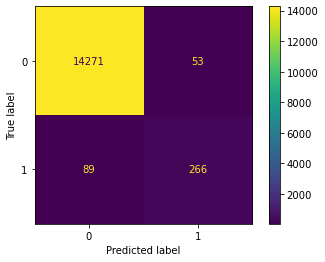

In [14]:
# Logistic Regression model
logreg_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32)) # max_iter called to resolve warning
])

model_fit_print(logreg_model, X, y)

In [15]:
df['target'].value_counts(normalize=True) # To show class imbalance

0    0.976087
1    0.023913
Name: target, dtype: float64


## After oversampling to deal with class imbalance

We see that 
<ul>
    <li><b>Accuracy Score decreased to 97.79%</b></li>
    <li><b>Precision Score decreased to 52.23%</b></li>
</ul>
This is still an improvement from our baseline model, but the precision is not ideal


    Train Accuracy: 98.28%
    Train Precision: 58.02%
    Test Accuracy: 97.79%
    Test Precision: 52.23%
    


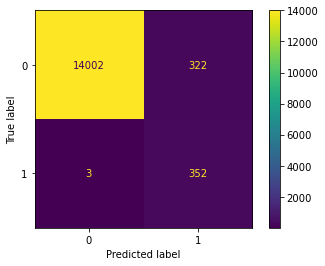

In [16]:
model_1 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32)) # max_iter called to resolve warning
])

model_fit_print(model_1, X, y)


# Model Two Decision Tree Classifier

---

<p>The next model I decided to use was a Decison Tree Classifier to improve the precision score
    For the first iteration I did not declare any stop parameters
    As expected the model is severly overfit producing a
<ul>
    <li><b>Training Accuracy Score of 100%</b></li>
    <li><b>Training Precision Score of 100%</b></li>
    ============And============
    <li><b>Testing Accuracy Score of 99.69%</b></li>
    <li><b>Testing Precision Score of 92.82%</b></li>
</ul>
</p> 


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 99.69%
    Test Precision: 92.82%
    


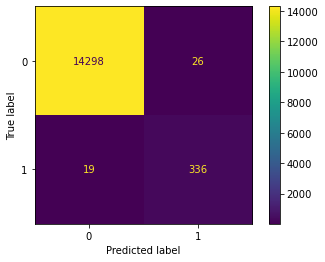

In [17]:
dtree_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(random_state=32))
])

model_fit_print(dtree_model, X, y)


## Finding Optimal Parameters with GridSearch

<p>To address the overfitting and in addition find the optimal parameters for the Decision Tree Classifier I implemented Grid Seach with the following parameters:<br>
<code>"criterion":['gini', 'entropy'],
"max_depth":[1, 10, 25, 50],
"min_samples_split":range(1, 10),
"min_samples_leaf":range(1, 10)</code><br>
==========================================<br>
After running the GridSearch it return the following as optimal parameters:<br>
<code>criterion= 'entropy'
max_depth= 25 
min_samples_split= 2
min_samples_leaf= 1</code><p>

In [18]:
# # Approximately 7 minute run time
# param_dict = {
#     "dtree__criterion":['gini', 'entropy'],
#     "dtree__max_depth":[1, 10, 25, 50],
#     "dtree__min_samples_split":range(1, 10),
#     "dtree__min_samples_leaf":range(1, 10)
# }

# gs = GridSearchCV(estimator=dtree_model,
#                  param_grid=param_dict,
#                  cv=10,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)


## After running with the optimal parameters

We see that 
<ul>
    <li><b>Training Accuracy Score 100%</b></li>
    <li><b>Training Precision Score 100%</b></li>
    ============And============
    <li><b>Testing Accuracy Score increased to 99.95%</b></li>
    <li><b>Testing Precision Score increased to 99.43%</b></li>
</ul>
These scores are extremely good and the overfitting has been resolved!


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 99.95%
    Test Precision: 99.43%
    


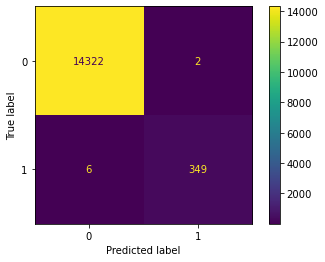

In [19]:
dtree_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 25, min_samples_split= 2,
                                    min_samples_leaf= 1, random_state= 32))
])

model_fit_print(dtree_model2, X, y)


# Model Three Random Forest Classifier

---

<p>For the third model I decided to use a RFC (Random Forest Classifier) because of how well the optimized Decision Tree Classifier performed. After running an initial RFC with no stopping parameters we find that it has amazing performace scores.

<ul>
    <li><b>Training Accuracy Score of 100%</b></li>
    <li><b>Training Precision Score of 100%</b></li>
    ============And============
    <li><b>Testing Accuracy Score of 99.79%</b></li>
    <li><b>Testing Precision Score of 97.65%</b></li>
</ul>
However, it is important to remember that without any stopping parameters declared this model is absolutely overfit. Even if the evaluation metrics show amazing model performance</p>


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 99.79%
    Test Precision: 97.65%
    


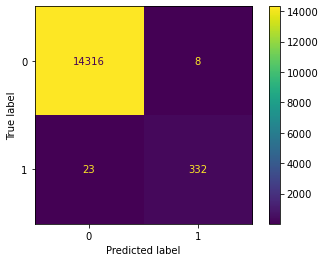

In [20]:
rforest_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(random_state = 32))
])

model_fit_print(rforest_model, X, y)


## Finding Optimal Parameters with GridSearch

<p>To address the overfitting and in addition find the optimal parameters for the Decision Tree Classifier I implemented Grid Seach with the following parameters:<br>
<code>"n_estimators":[30, 100, 150, 200],
"criterion":['gini', 'entropy'],
"max_depth":[1, 10, 25, 50],
"min_samples_split":range(1, 10),
"min_samples_leaf":range(1, 10)</code><br>
==========================================<br>
After running the GridSearch it return the following as optimal parameters:<br>
<code>criterion = 'entropy'
max_depth = 50 
min_samples_split = 2
min_samples_leaf = 2
n_estimators = 150</code><p>

In [21]:
# # Approximately 200 minute run time
# rforest_grid = imbpipline(steps=[
#     ("preprocessor", preprocessor),
#     ('SMOTE', SMOTE(random_state = 32)),
#     ("rf", RandomForestClassifier(random_state = 32))
# ])

# param_grid = {
#     "rf__n_estimators":[30, 100, 150, 200],
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)
# }            

# gs = GridSearchCV(estimator=rforest_grid,
#                  param_grid=param_grid,
#                  cv=10,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)


## After running with the optimal parameters

<p>We see that 
<ul>
    <li><b>Training Accuracy Score is 99.98%</b></li>
    <li><b>Training Precision Score is 99.9%</b></li>
    ============And============
    <li><b>Testing Accuracy Score increased to 99.85%</b></li>
    <li><b>Testing Precision Score decreased to 96.64%</b></li>
</ul>
These scores are extremely good and the overfitting has been resolved!<br>
Even though our testing scores dropped, the drop is negligible compared to the benefit of resolving an overfit model</p>


    Train Accuracy: 99.98%
    Train Precision: 99.9%
    Test Accuracy: 99.85%
    Test Precision: 96.64%
    


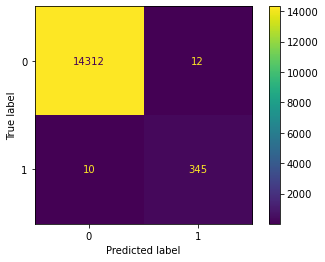

In [22]:
rforest_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(criterion = 'entropy', n_estimators = 150, max_depth = 50,
                                  min_samples_leaf = 2, min_samples_split = 2, random_state = 32))
])

model_fit_print(rforest_model2, X, y)


# Time Series

---

Next I decided to do a time series with my data<br>
First I create a timeseries with a date time index

In [23]:
tdf = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
tdf2 = tdf.select_dtypes(exclude="object")
tdf2 = tdf2['Price'] # Testing with just price
tdf2 = tdf2.resample('D').mean()
tdf2

departure_date
2022-04-10    1760.088889
2022-04-11    1693.311594
2022-04-12    1645.573643
2022-04-13    1721.958791
2022-04-14    1950.081281
                 ...     
2022-08-27    1470.635266
2022-08-28    1489.173077
2022-08-29    1383.706731
2022-08-30    1273.192308
2022-08-31    1305.837709
Freq: D, Name: Price, Length: 144, dtype: float64

Doing a quick analysis with describe we can see that there a decent gap between the min and max

In [24]:
tdf2.describe()

count     144.000000
mean     1789.256563
std       206.104975
min      1273.192308
25%      1678.096653
50%      1777.798753
75%      1939.753614
max      2391.075610
Name: Price, dtype: float64


## Train Test Splitting with a cutoff


In [25]:
cutoff = round(tdf2.shape[0]*0.8)

# Split train and test
train = tdf2[:cutoff]
test = tdf2[cutoff:]


## Checking for Stationarity

---

After running a dicky fuller test we see that our data is not stationary. We can again confirm this when we look at the plotted data.

In [26]:
# dicky_fuller(train.values.reshape(-1).tolist()) # Needed to run with all numeric columns
dicky_fuller(train)

The data is not stationary with a fuller score of 0.35


Test Statistic                  -1.862820
p-value                          0.349749
#Lags Used                       9.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64

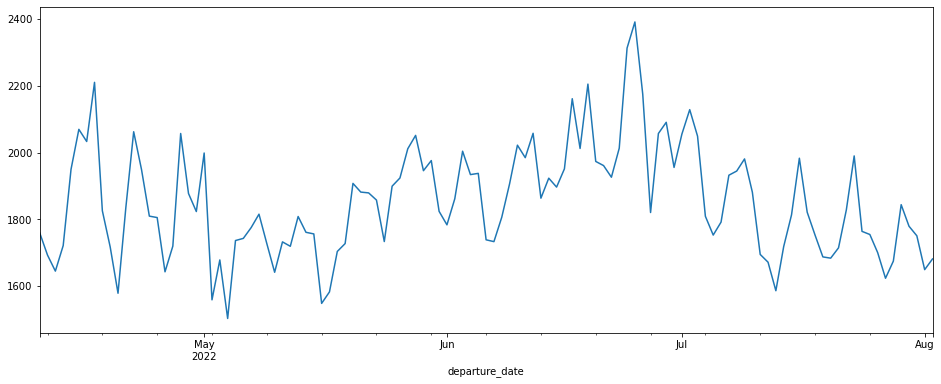

In [27]:
train.plot(figsize = (16,6));


# Naive Baseline

---

For the baseline time series model I chose the naive baseline.<br>
When checking the MSE of the baseline we see that it is approximately 140 dollars.

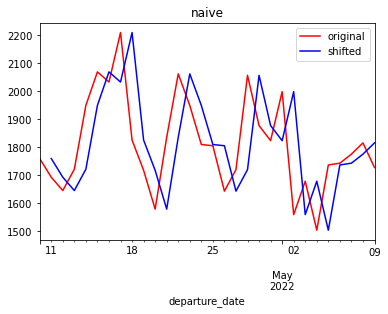

In [28]:
naive = train.shift(1)
naive

fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [29]:
mean_squared_error(train[1:], naive.dropna(), squared=False)

139.46791182347664


# Random Walk

---

For the next model I decided on a random walk. After fitting it and checking the MSE we see that it actually performed worse than the naive baseline.

In [30]:
random_walk_model = sm.tsa.arima.ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

214.98960374516483

From here I decided to find what the ideal AR and MA terms would be using acf and pacf.<br>
I also chose to use a period of 7 days because there was a weekly trend that seemed to be present

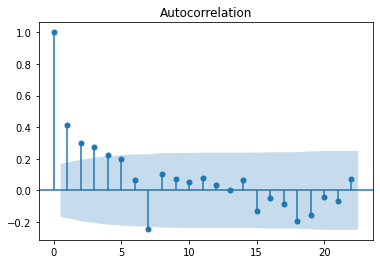

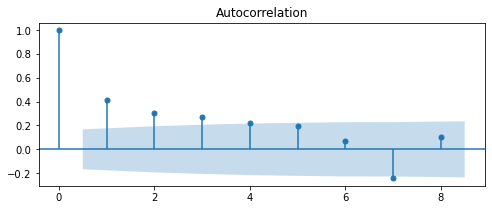

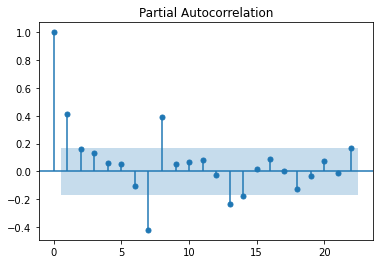

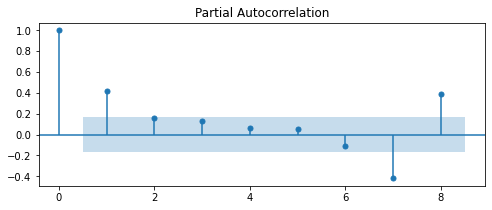

In [31]:
ts_daily_diff = tdf2.diff(periods= 7).dropna()

plot_acf(ts_daily_diff) #shown below is that an MA term of 5 seems ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(ts_daily_diff, ax=ax, lags=8);

plot_pacf(ts_daily_diff) #shown below is that an AR term of 2 is ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(ts_daily_diff, ax=ax, lags=8);


# Arima

---

After finding that the ideal AR and MA terms are 2 and 5 respectively I ran them through an ARIMA model.<br>
After doing this the MSE was lower than the random walk, but it is still higher than the naive baseline model!

In [32]:
ar_1 = sm.tsa.arima.ARIMA(train, order=(2, 1, 5)).fit()
ar_1.predict(typ='levels')
ar_1.summary()

C:\Users\Jun\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  115
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -689.326
Date:                Fri, 15 Apr 2022   AIC                           1394.653
Time:                        20:52:26   BIC                           1416.543
Sample:                    04-10-2022   HQIC                          1403.537
                         - 08-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2494      0.007    188.024      0.000       1.236       1.262
ar.L2         -0.9998      0.001   -725.856      0.000      -1.002      -0.997
ma.L1         -1.8760      0.153    -12.250      0.000      -2.176      -1.576
ma.L2          1.8041      0.314      5.740      0.000       1.188       2.420
ma.L3         -0.6218      0.305     -2.038      0.042      -1.220      -0.024
ma.L4         -0.0062      0.226     -0.027      0.978      -0.449       0.437
ma.L5          0.0311      0.110      0.281      0.778      -0.185       0.247
sigma2      1.139e+04   6.17e-05   1.85e+08      0.000    1.14e+04    1.14e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.19
Prob(Q):                              1.00   Prob(JB):                         0.91
Heteroskedasticity (H):               0.52   Skew:                             0.02
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.31e+24. Standard errors may be unstable.
"""

In [33]:
y_hat_ar1 = ar_1.predict(typ='levels')
mean_squared_error(train, y_hat_ar1, squared = False)

193.65719828839167

After plotting the predictions we see that the model is close to the actual data, but it is rounding out most of the predictions

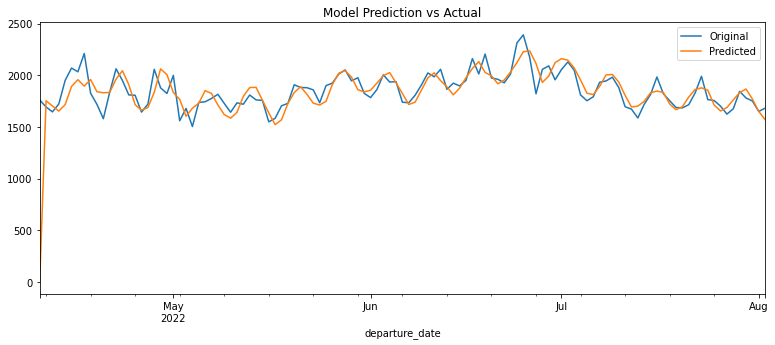

In [34]:
fig, ax = plt.subplots(figsize=(13,5), linewidth=2)
train.plot(ax=ax, label = 'Original')
y_hat_ar1.plot(ax=ax, label = 'Predicted')
ax.set_title('Model Prediction vs Actual')
ax.legend();

In [35]:
ar_1.forecast()

2022-08-03    1626.015197
Freq: D, dtype: float64


# Appendix for Findings and Graphs

---

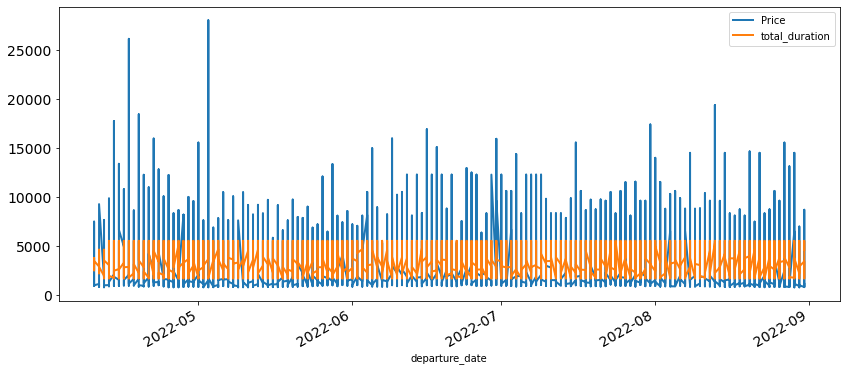

In [36]:
# Set date time index
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
time_df = time_df.filter(['Price', 'total_duration'], axis=1)

time_df.plot(figsize=(14,6), linewidth=2, fontsize=14);

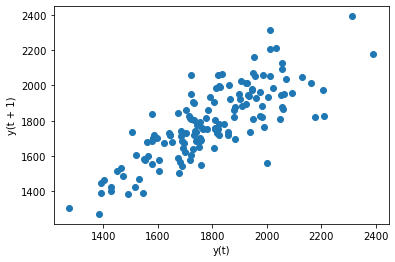

In [37]:
from pandas.plotting import lag_plot
lag_plot(tdf2)
plt.show()

In [38]:
def dummy_ts():
    """ Create a time series x with price 0. """
    df = pd.DataFrame(columns=['departure_date', 'Price'])
    df['departure_date'] = pd.date_range(start='2022-04-01', end='2022-04-10', freq='D')
    tdf = df.set_index('departure_date')
    
    return tdf

filler_time = dummy_ts()
temporarydf = pd.DataFrame(tdf2)
combined_tsdf = filler_time.append(temporarydf)
backfilled_tsdf = combined_tsdf.bfill()

In [39]:
snsdata = pd.DataFrame(tdf2)
snsdata = snsdata.reset_index()


## Creating a plot to use for presentation

---


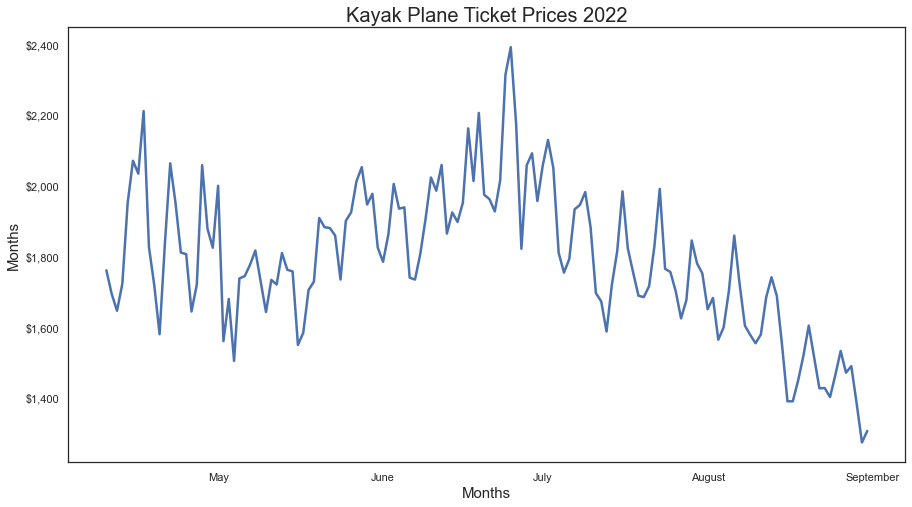

In [40]:
import seaborn as sns
sns.set(rc = {"figure.figsize":(15,8)})
sns.set_style("white")

sns_plot = sns.lineplot(data=snsdata, 
                         x="departure_date", y="Price", linewidth = 2.5)


sns_plot.set_title("Kayak Plane Ticket Prices 2022", fontsize = 20)
sns_plot.set_xlabel("Months", fontsize = 15)
sns_plot.set_ylabel("Months", fontsize = 15)

plt.xticks(["2022-05", "2022-06", "2022-07", "2022-08", "2022-09"],
          ["May", "June", "July", "August", "September"])

plt.yticks([1400, 1600, 1800, 2000, 2200, 2400],
          ["$1,400", "$1,600", "$1,800", "$2,000", "$2,200", "$2,400"])

# plt.savefig('Price Lineplot.png', dpi = 300)
plt.show()

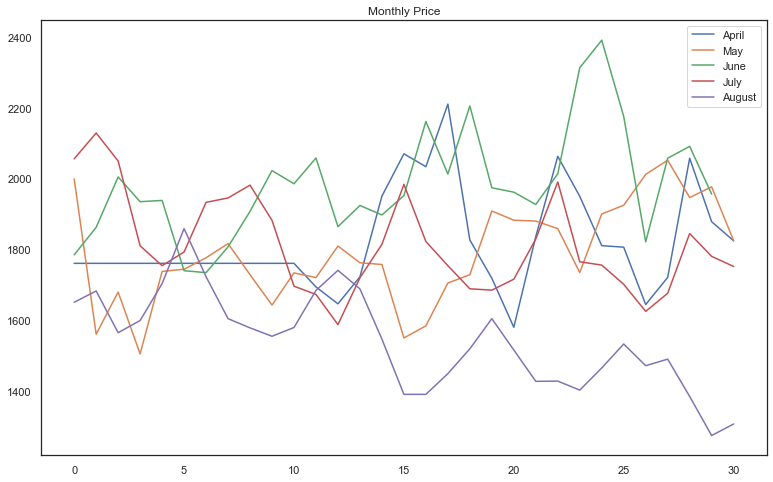

In [41]:
# Use pandas grouper to group values using annual frequency
monthly_groups = backfilled_tsdf.groupby(pd.Grouper(freq ='M'))

month_title_list = ['April', 'May', 'June', 'July', 'August']
# Create a new DataFrame and store yearly values in columns 
apr_monthly = pd.DataFrame()
may_monthly = pd.DataFrame()
jun_monthly = pd.DataFrame()
jul_monthly = pd.DataFrame()
aug_monthly = pd.DataFrame()

n = 0

for mon, group in monthly_groups:
    if n == 0:
        apr_monthly[mon.month] = group.values.ravel()
    if n == 1:
        may_monthly[mon.month] = group.values.ravel()
    if n == 2:
        jun_monthly[mon.month] = group.values.ravel()
    if n == 3:
        jul_monthly[mon.month] = group.values.ravel()
    if n == 4:
        aug_monthly[mon.month] = group.values.ravel()
    n += 1

fig, ax = plt.subplots(figsize=(13,8))
apr_monthly.plot(ax=ax, label = 'April')
may_monthly.plot(ax=ax, label = 'May')
jun_monthly.plot(ax=ax, label = 'June')
jul_monthly.plot(ax=ax, label = 'July')
aug_monthly.plot(ax=ax, label = 'August')
ax.set_title('Monthly Price')
ax.legend([month for month in month_title_list]);


## Inspecting plots for each month for findings

---


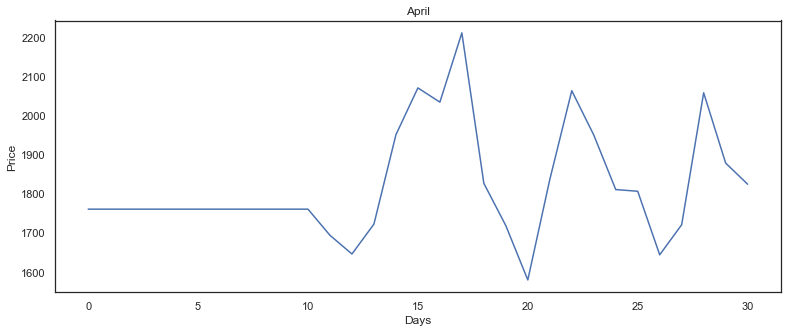

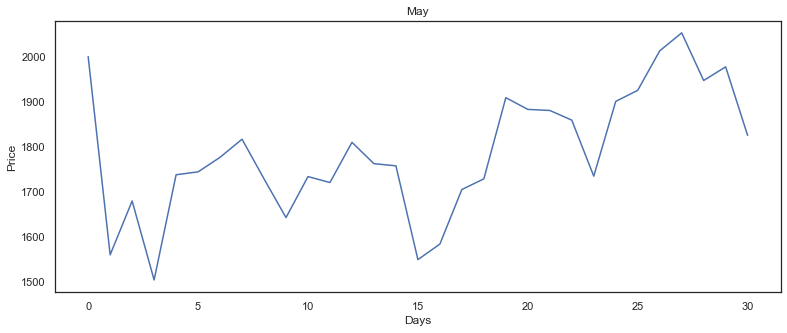

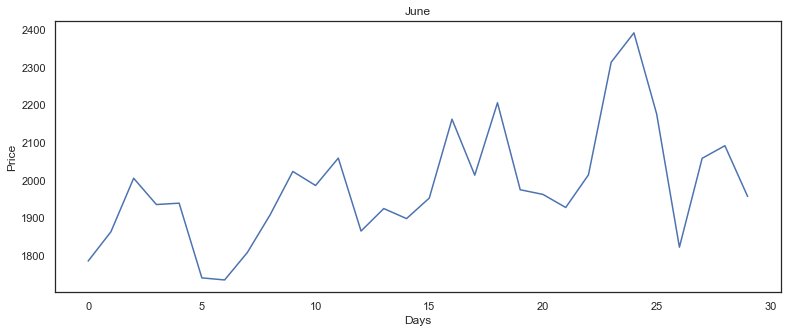

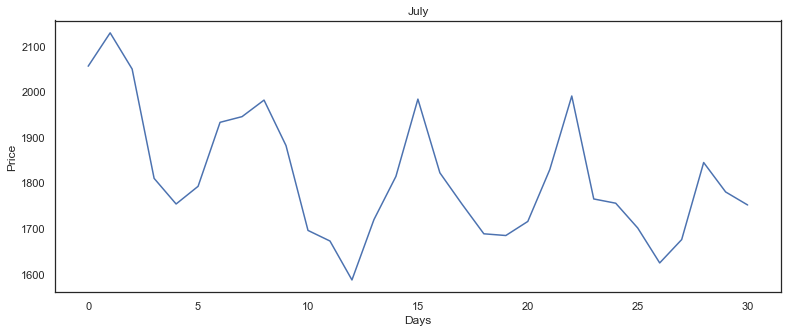

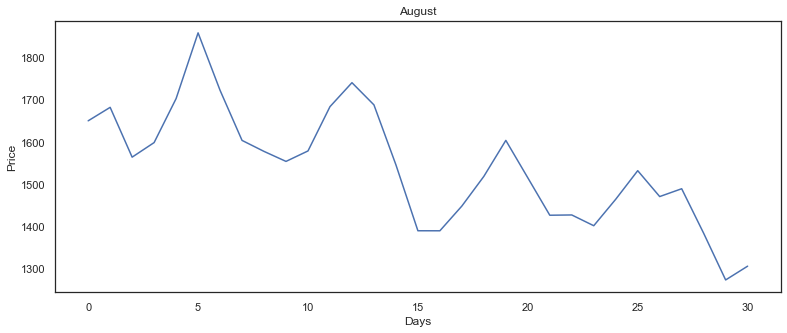

In [42]:
monthly_list = [apr_monthly, may_monthly, jun_monthly,
           jul_monthly, aug_monthly]
i = 0

for month_ts in monthly_list:
    fig, ax = plt.subplots(figsize=(13,5))
    ax.plot(month_ts)
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.set_title(label=month_title_list[i])
    i += 1

Here I was checking the price ranges for the week days that had the lowest price trends from the plot<br>
We can see that the average price across these days was \\$1715 with the median being approximately \\$1500.

In [43]:
checker = df.loc[(df['departure_day'] == 'Tuesday') | (df['departure_day'] == 'Thursday') |
          (df['departure_day'] == 'Monday') | (df['departure_day'] == 'Wednesday')]
checker.loc[checker['Price'] < 25000]['Price'].describe()

count    33855.000000
mean      1714.811431
std       1059.830468
min        812.000000
25%       1178.000000
50%       1490.000000
75%       1859.000000
max      18431.000000
Name: Price, dtype: float64

Here I checked the prices for the weekend to compare them with the weekday prices that had the lowest trends.<br>
We see that the average was \\$1890 with the median being approximately \\$1600.

In [44]:
checker2 = df.loc[(df['departure_day'] == 'Friday') | (df['departure_day'] == 'Saturday') |
          (df['departure_day'] == 'Sunday')]
checker2.loc[checker2['Price'] < 25000]['Price'].describe()

count    24855.000000
mean      1889.383504
std       1282.621069
min        845.000000
25%       1277.000000
50%       1599.000000
75%       1997.000000
max      19374.000000
Name: Price, dtype: float64

In [45]:
# Create dataframe with only targets to inspect
findings = df.loc[df['target'] == 1]


## Checking Prices

---

Inspecting the prices between the whole dataset and the findings we can clearly see that there is a huge difference which is exactly what we want. We want the cheapest ticket prices.<br>
We also see that the bulk of the prices are between \\$915 and \\$1020.

In [46]:
display(df['Price'].describe())
display(df['Price'].value_counts().head())

count    58713.000000
mean      1789.992080
std       1176.175647
min        812.000000
25%       1220.000000
50%       1536.000000
75%       1909.000000
max      28005.000000
Name: Price, dtype: float64

915     763
1020    333
918     333
1136    282
968     277
Name: Price, dtype: int64

In [47]:
display(findings['Price'].describe())
display(findings['Price'].value_counts())

count    1404.000000
mean     1180.861111
std       191.999450
min       817.000000
25%      1020.000000
50%      1175.500000
75%      1330.500000
max      1521.000000
Name: Price, dtype: float64

1020    66
915     42
1483    31
1476    31
1330    28
        ..
1062     1
1059     1
1058     1
1312     1
1186     1
Name: Price, Length: 343, dtype: int64


## Checking Duration

---

When taking a look at the durations we can see that we have filtered out the longest flights as intended!<br>
We can also see that the average duration is approximately 500 minutes or 8 hours shorter.<br>
This is good because we want the cheapest flights while not compromising too much on the length of the flights because no one wants to be wasting time with layovers and connecting flights.

In [48]:
display(df['total_duration'].describe())
display(df['total_duration'].value_counts())

count    58713.000000
mean      2975.479110
std        748.548357
min       1725.000000
25%       2330.000000
50%       2905.000000
75%       3515.000000
max       5549.000000
Name: total_duration, dtype: float64

2860    963
2236    934
2568    900
2324    852
3762    832
       ... 
4635     80
3890     67
4200     32
3424     24
3195      1
Name: total_duration, Length: 249, dtype: int64

In [49]:
display(findings['total_duration'].describe())
display(findings['total_duration'].value_counts())

count    1404.000000
mean     2493.948006
std       444.750814
min      1725.000000
25%      2236.000000
50%      2625.000000
75%      2860.000000
max      3615.000000
Name: total_duration, dtype: float64

2635    197
2236    195
3050    154
2860    145
1757     59
2955     57
2239     52
1805     50
2270     46
2625     45
2720     44
1830     41
2670     30
1800     30
1730     28
2380     19
2292     16
2273     15
2581     15
1790     14
2280     14
1725     13
2165     12
3243     12
2505     10
2600      9
3465      9
3500      9
2387      9
2185      9
3480      9
2540      8
3325      4
1810      3
3324      3
2235      2
1960      2
3615      2
1795      2
2840      2
2590      1
2815      1
2830      1
2835      1
2845      1
3555      1
2250      1
3589      1
3590      1
Name: total_duration, dtype: int64


## Departure Times

---

Here I wanted to find out which departure times were most prevalent among the cheapest flights. We see that most of them either take place early in the morning or at night after 6pm. <br>
This is good to keep in mind for future recommendations.

In [50]:
(findings['dep_time'] + findings['am_pm']).value_counts(normalize=True)

7:38pm     0.131054
6:34am     0.092593
11:25pm    0.068376
5:20am     0.056268
5:20pm     0.053419
8:00am     0.049858
6:34pm     0.046296
9:55pm     0.046296
11:25am    0.043447
7:13am     0.039174
7:46am     0.037749
7:38am     0.037749
6:30am     0.037037
1:10am     0.035613
11:20pm    0.027066
6:55am     0.025641
1:50am     0.022080
6:55pm     0.014957
4:05pm     0.013533
6:45pm     0.012821
7:15am     0.009972
6:05am     0.009259
1:42am     0.008547
1:10pm     0.007835
1:50pm     0.007123
9:55am     0.007123
11:55am    0.006410
7:13pm     0.005698
12:05am    0.005698
12:55pm    0.005698
11:20am    0.005698
12:55am    0.005698
7:46pm     0.004274
10:25pm    0.004274
12:21am    0.002137
10:25am    0.002137
10:30pm    0.002137
2:40am     0.001425
9:30am     0.001425
12:40am    0.000712
1:40am     0.000712
6:25pm     0.000712
6:20am     0.000712
8:55pm     0.000712
6:20pm     0.000712
1:40pm     0.000712
8:10am     0.000712
7:00am     0.000712
dtype: float64


## Is there a difference WHEN we look up the ticket?

---

For the most part there does not seem to be a difference of when we actually look up the ticket except when we hit about 4 months or 120 days from the departure date. After approximately 4 months the price seems to get cheaper which is also reflected in the plot of the data.<br>
It is still important to keep in mind that we do not have a full view of a longer period of time and the tickets were constrained to only 3 destinations and 3 departure states.

In [51]:
display(df['time_diff'].value_counts())
display(findings['time_diff'].value_counts().head(40))

90     554
91     554
93     554
92     554
94     549
      ... 
17     398
28     397
7      391
145    235
146     47
Name: time_diff, Length: 140, dtype: int64

143    42
142    39
144    37
138    33
15     29
139    29
130    28
141    28
137    28
136    28
129    26
131    22
123    21
140    21
102    20
14     20
27     18
135    18
128    18
132    17
117    17
145    17
22     17
41     16
30     16
40     16
95     16
16     16
108    15
38     15
26     15
31     14
122    14
125    14
39     14
13     14
115    13
33     13
42     13
36     13
Name: time_diff, dtype: int64


## Does the Airline Matter?

---

Checking which airlines are present with the cheapest tickets it is unsurprisingly made up of United, American and Korean Air. This is also because of the destinations chosen which would very clearly introduce some heavy bias simply because of the nature of international flights and the destinations we have chosen.

In [52]:
display(df['dep_airline'].value_counts())
display(findings['dep_airline'].value_counts())

American Airlines     13543
United Airlines       12548
Qatar Airways          7099
Delta                  5419
Korean Air             4973
Singapore Airlines     3479
Alaska Airlines        3141
ANA                    1977
Air India              1289
SAS                    1128
Emirates                843
SWISS                   572
Turkish Airlines        495
Air Canada              425
British Airways         415
JetBlue                 286
Lufthansa               284
Asiana Airlines         283
Thai Airways            141
Japan Airlines          141
Brussels Airlines       140
Multiple Airlines        92
Name: dep_airline, dtype: int64

United Airlines       367
SAS                   211
American Airlines     198
Korean Air            169
ANA                   157
Qatar Airways          93
Delta                  68
Emirates               55
Singapore Airlines     30
Alaska Airlines        15
Asiana Airlines        14
British Airways         9
Air India               8
Lufthansa               4
SWISS                   3
Thai Airways            2
Brussels Airlines       1
Name: dep_airline, dtype: int64

In [53]:
display(df['ret_airline'].value_counts())
display(findings['ret_airline'].value_counts())

Qatar Airways         11446
United Airlines        8425
American Airlines      7651
ANA                    5519
Korean Air             5115
Singapore Airlines     4903
Delta                  4426
Emirates               2244
Asiana Airlines        2124
Thai Vietjet Air       1533
Thai Airways           1127
Japan Airlines         1029
Air Canada              943
Turkish Airlines        636
SWISS                   429
Lufthansa               286
AirAsia                 282
Bangkok Airways         172
Austrian Airlines       141
JetBlue                 141
IndiGo                  141
Name: ret_airline, dtype: int64

United Airlines       264
Thai Airways          211
ANA                   207
American Airlines     195
Korean Air            170
Emirates               87
Singapore Airlines     69
Qatar Airways          62
Asiana Airlines        57
Delta                  30
Japan Airlines         26
Air Canada             19
IndiGo                  4
SWISS                   2
Thai Vietjet Air        1
Name: ret_airline, dtype: int64


## Checking for the departure date and stops

---

This is where I found the most surprising finding. We see that when looking at which departure dates made up the cheapest flights it is primarily made up of the weekdays with Tuesday making up 22% of the tickets.<br>
When Looking at the total stops (connecting flights) we see that unsurprisingly having 2 stops (1 for departure and return) is the most common.

In [54]:
display(df['departure_day'].value_counts())
display(findings['departure_day'].value_counts(normalize=True))

Wednesday    8656
Tuesday      8516
Monday       8431
Sunday       8321
Saturday     8283
Friday       8253
Thursday     8253
Name: departure_day, dtype: int64

Tuesday      0.216524
Monday       0.200142
Wednesday    0.188034
Thursday     0.143162
Sunday       0.098291
Saturday     0.078348
Friday       0.075499
Name: departure_day, dtype: float64

In [56]:
display(df['total_stops'].value_counts())
display(findings['total_stops'].value_counts())

2    23375
3    13346
4    12656
1     5233
0     2554
5     1053
6      496
Name: total_stops, dtype: int64

2    776
3    332
4    249
5     22
1     21
6      4
Name: total_stops, dtype: int64